# TDA & Deep Learning Project Perslay Application 2


#### Floran DEFOSSEZ Gatien Chopard Sebastien ROIG

Ce notebook a pour objectif de présenter une deuxième utilisation de l'article "PersLay: A Simple and Versatile Neural Network Layer for Persistence Diagrams", cette fois pour des données d'un autre type, des graphes.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.io import loadmat
import networkx as nx
import numpy as np
import os 
from scipy.sparse import csgraph
from scipy.linalg import eigh
import gudhi as gd
import gudhi.representations as tda
from sklearn.preprocessing import MinMaxScaler
from tensorflow import random_uniform_initializer as rui
from sklearn.model_selection import train_test_split
import tensorflow_addons  as tfa



## Présentation du jeu de données

MUTAG est une collection de composés nitroaromatiques et l'objectif est de prédire leur mutagénicité sur Salmonella typhimurium.
Il y a deux étiquettes discrètes (0 ou 1) et c'est ce que nous devons classer. Chaque nœud possède également une étiquette, mais nous n'utiliserons pas cette information dans le cadre de cette étude. Pour prendre cela en compte, il aurait été intéressant de faire un réseau multicanal avec la partie TDA et une autre partie prenant en compte ces étiquettes de nœuds.



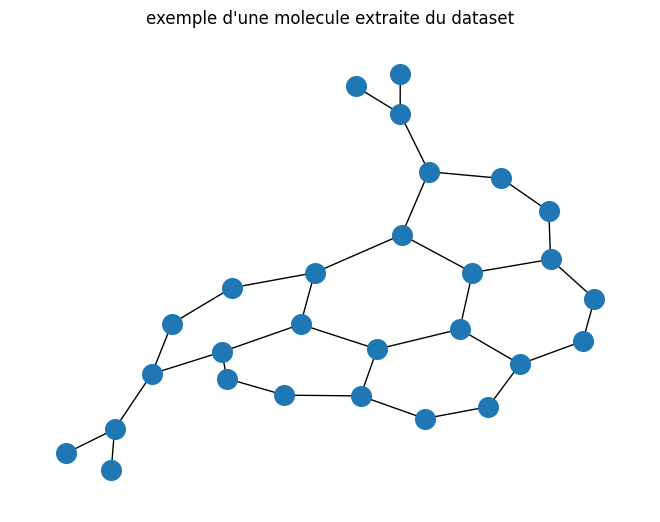

label de cette molécule : 1


In [2]:
ex = "C:/Users/sebas/Desktop/TDA_project/data/MUTAG/mat/nodes_28_gid_180_lb_1_index_1_adj.mat"
# Les données sont stockées dans des fichiers .mat, la fonction loadmat nous permet de lire facilement
# ces fichiers.

data = loadmat(ex)
label = int(ex[ex.index('lb')+3])
# La matrice d'adjacence caractérise les liens entre chaque nœud, si le ième nœud et le jème nœud sont
# connectés alors il y a un 1 dans la matrice sinon un 0.
adj = np.array(data['A'], dtype = np.float32)

# Affichage du graphe.
rows, cols = np.where(adj == 1)
edges = zip(rows.tolist(), cols.tolist())
gr = nx.Graph()
gr.add_edges_from(edges)
nx.draw(gr, node_size=200)
plt.title("exemple d'une molecule extraite du dataset")
plt.show()
print('label de cette molécule :', label)

Pour ce type de structure de données, nous allons utiliser un autre type de filtration qui est basé sur la filtration par sous-niveaux de fonctions. Ici, la particularité est la fonction qui va servir à cette filtration, nous allons la définir ici :

Si $A$ est la matrice d'adjacence du graphe $(G,V)$, et $D_{i,i} = \sum_{j} A_{i,j}$ la matrice de degrée. Alors on définit l'opérateur Laplacien normalisée comme suit : $L_w = I - D^{-1/2}AD^{-1/2}$.
Cette matrice possède une base orthonormale $(\psi_1, ... , \psi_n)$ associée aux valeurs propres $(\lambda_1, ... , \lambda_n)$. La heat kernel signature est ensuite définie pour un $t>0$ comme suit :
$$hks_{G,t} = \sum_{i=1}^{n} exp(-t\lambda_k)\psi_k(v)^2$$
On peut ensuite procéder à une filtration par sous-niveau de cette fonction pour un certain $t$, ou plusieurs si on veut plus d'informations.

In [3]:
def HKS(egvec, egval, t):
    return np.square(egvec).dot(np.diag(np.exp(-t*egval))).sum(axis=1)

Comme nous avons à faire à des graphes, nous utilisons ici la persistance étendue afin de capter toute l'information.

In [4]:
def extended_persistance(adj, values):
    
    num_vertices = adj.shape[0]
    (xs, ys) = np.where(np.triu(adj))
    st = gd.SimplexTree()
    for i in range(num_vertices):
        st.insert([i], filtration=-1e10)
    for x, y in zip(xs, ys):        
        st.insert([x, y], filtration=-1e10)
    for i in range(num_vertices):
        st.assign_filtration([i], values[i])
    st.make_filtration_non_decreasing()
    st.extend_filtration()
    LD = st.extended_persistence()
    dgmOrd0, dgmRel1, dgmExt0, dgmExt1 = LD[0], LD[1], LD[2], LD[3]
    dgmOrd0 = np.vstack([np.array([[ min(p[1][0],p[1][1]), max(p[1][0],p[1][1]) ]]) for p in dgmOrd0 if p[0] == 0]) if len(dgmOrd0) else np.empty([0,2])
    dgmRel1 = np.vstack([np.array([[ min(p[1][0],p[1][1]), max(p[1][0],p[1][1]) ]]) for p in dgmRel1 if p[0] == 1]) if len(dgmRel1) else np.empty([0,2])
    dgmExt0 = np.vstack([np.array([[ min(p[1][0],p[1][1]), max(p[1][0],p[1][1]) ]]) for p in dgmExt0 if p[0] == 0]) if len(dgmExt0) else np.empty([0,2])
    dgmExt1 = np.vstack([np.array([[ min(p[1][0],p[1][1]), max(p[1][0],p[1][1]) ]]) for p in dgmExt1 if p[0] == 1]) if len(dgmExt1) else np.empty([0,2])
    return dgmOrd0, dgmExt0, dgmRel1, dgmExt1



## Preprocessing des données

Les étapes du preprocessing des données sont les suivantes :

- Extraction de la matrice d'adjacence du fichier et extraction du label
- Construction du Laplacien normalisée puis calcul de la Heat kernel signature pour chaque graphe
- Construction des 4 diagrammes de persistance étendue correspondants
- Scaling des points dans le carré unité 
- Complétion des diagrammes pour qu'ils aient tous le même nombre de points et ajout du masque

In [5]:
dir = 'data/MUTAG/mat'
files = os.listdir(dir)

n = len(files)
labels = np.zeros(n)
features = []

# dataset building
for i, file in enumerate(files):
    data = loadmat(dir + '/' +file)
    labels[i] = int(file[file.index('lb')+3])
    adj = np.array(data['A'], dtype = np.float32)
    L = csgraph.laplacian(adj, normed = True)
    egval, egvect = eigh(L)
    values = HKS(egvect,egval,1)
    dgmOrd0, dgmExt0, dgmRel1, dgmExt1 = extended_persistance(adj, values)
    features.append(dgmOrd0)
    features.append(dgmExt0)
    features.append(dgmRel1)
    features.append(dgmExt1)
    
# Scaling des points dans le carré unité 
features = tda.DiagramScaler(use=True, scalers=[([0,1], MinMaxScaler())]).fit_transform(features)
# Remplissage des diagrammes afin qu'ils comportent tous le même nombre de points.
features = tda.Padding(use=True).fit_transform(features)

features = np.array(features)
features = np.reshape(features, (188,4,13,3))
labels = np.array(labels, dtype = np.int32)   

## Définition du modèle

Nous utlisons le même modèle que dans le notebook précédent. Cependant, nous traitons dans ce cas 4 diagrammes en parallèles qui correspondent aux 4 diagrammes de la persistance étendue. De plus la fonction $\phi$ de transformation des points est différente. En effet, ici : $$\phi(p) =(\frac{1}{\sqrt{2 \pi \sigma^2}} exp(- \|p - t_1\|^2 / (2 \sigma^2)), ... , \frac{1}{\sqrt{2 \pi \sigma^2}} exp(- \|p - t_q\|^2 / (2 \sigma^2))) ,\:(t_1,...,t_q)\in{\mathbb{R}^{2q}}$$.  
Plus précisément, nous calculerons cette transformation des points sur une discrétisation de 21*21 points du carré unité, ce qui nous donne ensuite une sorte "d'image" de 21 par 21 pixels. A noté qu'ici le paramètre à optimiser est $\sigma$ qui est différent pour les 4 types de digramme.  
On pondère ensuite chaque image par la même fonction w définie dans le notebook précédent, et on somme ensuite toutes ces images.  
La dernière différence est qu'avant de concaténer les features extraites des 4 diagrammes, on procède à une opération de convolution sur ces "images". On concatène le tout et on le fait passer par la fonction $\rho$.  
Voici une image qui résume les opérations effectuées :

<img src="images/perslayModelGraphs.png"  style="width: 800px;"/>

In [6]:
class PerslayModel(tf.keras.Model):
    def __init__(self):
        super(PerslayModel, self).__init__()

        self.weight =  [tf.Variable(name="weight", initial_value=rui(1.,1.)([10,10]), trainable = True) for _ in range(4)]
        self.layer_vars = tf.Variable(name ="vars", initial_value = rui(3.,3.)([4]), trainable = True)
        self.image_bnds = ((-0.001, 1.001), (-0.001, 1.001))
        self.image_size = (20, 20)
        self.fmodel = [tf.keras.Sequential([tf.keras.layers.Conv2D(10, 2, input_shape=(21,21,1)), tf.keras.layers.Flatten()]) for _ in range(4)]
        self.rho = tf.keras.Sequential([tf.keras.layers.Dense(1, activation="sigmoid", input_shape=(16000,))])

        
    def call(self, inputs, training=False):
        list_v = []
        # 4 type of diagrams
        for nf in range(4):
            diag = inputs[:,nf,:,:]
            tensor_diag = diag[:,:,:-1]
            tensor_mask = diag[:,:,-1]
            
            # Compute weights
            grid_shape = self.weight[nf].shape  
            indices = []
            for dim in range(2):
                [m, M] = (-0.001, 1.001)
                coords = tf.slice(tensor_diag, [0, 0, dim], [-1, -1, 1])
                ids = grid_shape[dim] * (coords - m)/(M - m)
                indices.append(tf.cast(ids, tf.int32))
            weight = tf.expand_dims(tf.gather_nd(params=self.weight[nf], indices=tf.concat(indices, axis=2)), -1)

            # Compute layer
            num_pts = tensor_diag.shape[1]
            coords = [tf.range(start=self.image_bnds[i][0], limit=self.image_bnds[i][1], delta=(self.image_bnds[i][1] - self.image_bnds[i][0]) / self.image_size[i]) for i in range(2)]
            M = tf.meshgrid(*coords)
            t = tf.concat([tf.expand_dims(tens, 0) for tens in M], axis=0)
            bp_inp = tf.einsum("ijk,kl->ijl", tensor_diag, tf.constant(np.array([[1.,-1.],[0.,1.]], dtype=np.float32)))
            bc_inp = tf.reshape(bp_inp, [-1, num_pts, 2] + [1, 1])
            sg = self.layer_vars[nf]
            tensor_diag = tf.expand_dims(tf.math.exp(tf.math.reduce_sum(  -tf.math.square(bc_inp-t) / (2*tf.math.square(sg)),  axis=2)) / (2*np.pi*tf.math.square(sg)), -1)
            
            # Apply weight
            output_dim = len(tensor_diag.shape) - 2
            for _ in range(output_dim-1):
                weight = tf.expand_dims(weight, -1)
            tiled_weight = tf.tile(weight, [1, 1] + tensor_diag.shape[2:])
            tensor_diag = tf.math.multiply(tensor_diag, tiled_weight)

            # Apply mask
            for _ in range(output_dim):
                tensor_mask = tf.expand_dims(tensor_mask, -1)
            tiled_mask = tf.tile(tensor_mask, [1, 1] + tensor_diag.shape[2:])
            masked_layer = tf.math.multiply(tensor_diag, tiled_mask)

            # Permutation invariant operation sum
            vector = tf.math.reduce_sum(masked_layer, axis=1)
            
            # Convolution operation
            vector = self.fmodel[nf](vector)
            list_v.append(vector)

        representations = tf.concat(values=list_v, axis=1)
        final_representations = self.rho(representations)

        return final_representations  

## Entrainement du modèle

In [7]:
epochs    = 300
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.3, shuffle = True)

Pour les paramètres d'optimisation nous reprenons ici les paramètres utilisés lors de l'expérience du papiers "PersLay: A Simple and Versatile Neural Network Layer for Persistence Diagrams" pour ce même dataset.

In [8]:
model = PerslayModel()
lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=20, decay_rate=0.5, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-4)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = [tf.keras.metrics.BinaryAccuracy()]
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)


In [9]:
with tf.device('/device:CPU:0'):
    callbacks =  tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights=True)
    history = model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=32, shuffle = True, callbacks = callbacks, verbose = 0)
    train_results = model.evaluate(x_train, y_train, verbose = 0)
    test_results = model.evaluate(x_test,  y_test, verbose = 0)


final train accuracy :  84.7328245639801 %
final test accuracy :  89.47368264198303 %


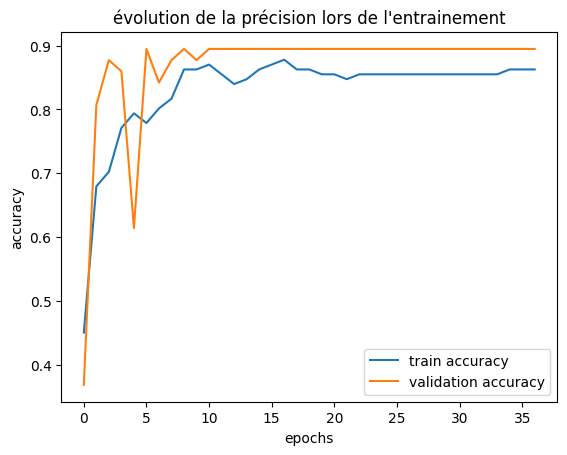

In [10]:
print('final train accuracy : ', train_results[1]*100, '%')
print('final test accuracy : ', test_results[1]*100, '%')

plt.plot(history.history['binary_accuracy'], label = 'train accuracy')
plt.plot(history.history['val_binary_accuracy'], label = 'validation accuracy')
plt.title("évolution de la précision lors de l'entrainement")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Nous obtenons donc des résultats similaires à l'article qui obtient une précision d'environ 89.8%.